In [3]:
import lxml.etree

tree = lxml.etree.parse('Shrew.xml')

print(tree)

In [5]:
print(lxml.etree.tostring(tree).decode()[0:500])

<?xml-stylesheet type="text/xsl" href="fdt.xsl"?><TEI xmlns="http://www.tei-c.org/ns/1.0">
<teiHeader>
<fileDesc>
<titleStmt>
<title>The Taming of the Shrew</title>
<author>William Shakespeare</author>
<editor xml:id="BAM">Barbara A. Mowat</editor>
<editor xml:id="PW">Paul Werstine</editor>
<respStmt>
<resp>Edited for XML and encoded by</resp>
<persName xml:id="MSP">Michael Poston</persName>
<persName xml:id="RLN">Rebecca Niles</persName>
</respStmt>
</titleStmt>
<editionStmt>
<edition n="0.9.2.


In [6]:
print(tree.getroot().tag)

print(len(tree.getroot()))

for child in tree.getroot():
    print(child.tag, child.attrib)
    for nested in child:
        print(nested.tag, nested.attrib)


{http://www.tei-c.org/ns/1.0}TEI
2
{http://www.tei-c.org/ns/1.0}teiHeader {}
{http://www.tei-c.org/ns/1.0}fileDesc {}
{http://www.tei-c.org/ns/1.0}encodingDesc {}
{http://www.tei-c.org/ns/1.0}profileDesc {}
{http://www.tei-c.org/ns/1.0}revisionDesc {}
{http://www.tei-c.org/ns/1.0}text {}
{http://www.tei-c.org/ns/1.0}front {}
{http://www.tei-c.org/ns/1.0}body {}
{http://www.tei-c.org/ns/1.0}back {}


In [7]:
start = tree.getroot()[1][1]
print(start.tag)
for child in start:
    print (child.tag)

{http://www.tei-c.org/ns/1.0}body
{http://www.tei-c.org/ns/1.0}pb
{http://www.tei-c.org/ns/1.0}div1
{http://www.tei-c.org/ns/1.0}lb
{http://www.tei-c.org/ns/1.0}milestone
{http://www.tei-c.org/ns/1.0}pb
{http://www.tei-c.org/ns/1.0}div1
{http://www.tei-c.org/ns/1.0}lb
{http://www.tei-c.org/ns/1.0}milestone
{http://www.tei-c.org/ns/1.0}pb
{http://www.tei-c.org/ns/1.0}div1
{http://www.tei-c.org/ns/1.0}div1
{http://www.tei-c.org/ns/1.0}lb
{http://www.tei-c.org/ns/1.0}milestone
{http://www.tei-c.org/ns/1.0}pb
{http://www.tei-c.org/ns/1.0}div1
{http://www.tei-c.org/ns/1.0}lb
{http://www.tei-c.org/ns/1.0}milestone
{http://www.tei-c.org/ns/1.0}pb
{http://www.tei-c.org/ns/1.0}div1
{http://www.tei-c.org/ns/1.0}lb
{http://www.tei-c.org/ns/1.0}milestone


In [8]:
#this won't work - need the namespace (as shown above)

print(tree.getroot().find('title'))

#using a namespace map

NSMAP = {'tei': 'http://www.tei-c.org/ns/1.0'}
print(tree.getroot().find('.//tei:title', namespaces=NSMAP).text)

None
The Taming of the Shrew


In [9]:
def character_network(tree):
    """Construct a character interaction network.

    Construct a character interaction network for Shakespeare texts in
    the Folger Digital Text collection. Character interaction networks
    are constructed on the basis of successive speaker turns in the texts,
    and edges between speakers are created when their utterances follow
    one another.

    Arguments:
        tree: An lxml.ElementTree instance representing one of the XML
            files in the Folger Shakespeare collection.

    Returns:
        A character interaction network represented as a weighted,
        undirected NetworkX Graph.

    """
    G = nx.Graph()
    # extract a list of speaker turns for each scene in a play
    for scene in tree.iterfind('.//tei:div2[@type="scene"]', NSMAP):
        speakers = scene.findall('.//tei:sp', NSMAP)
        # iterate over the sequence of speaker turns...
        for i in range(len(speakers) - 1):
            # ... and extract pairs of adjacent speakers
            try:
                speaker_i = speakers[i].attrib['who'].split('_')[0].replace('#', '')
                speaker_j = speakers[i + 1].attrib['who'].split('_')[0].replace('#', '')
                # if the interaction between two speakers has already
                # been attested, update their interaction count
                if G.has_edge(speaker_i, speaker_j):
                    G[speaker_i][speaker_j]['weight'] += 1
                # else add an edge between speaker i and j to the graph
                else:
                    G.add_edge(speaker_i, speaker_j, weight=1)
            except KeyError:
                continue
    return G


In [10]:
import networkx as nx
import matplotlib.pyplot as plt

G = character_network(tree.getroot())
print(f"N nodes = {G.number_of_nodes()}, N edges = {G.number_of_edges()}")

N nodes = 37, N edges = 93


In [11]:
import collections

interactions = collections.Counter()

for speaker_i, speaker_j, data in G.edges(data=True):
    interaction_count = data['weight']
    interactions[speaker_i] += interaction_count
    interactions[speaker_j] += interaction_count

nodesizes = [interactions[speaker] * 5 for speaker in G]

(-0.5426881807236859,
 0.43440579478915436,
 -1.0919205296509888,
 0.9303311226707658)

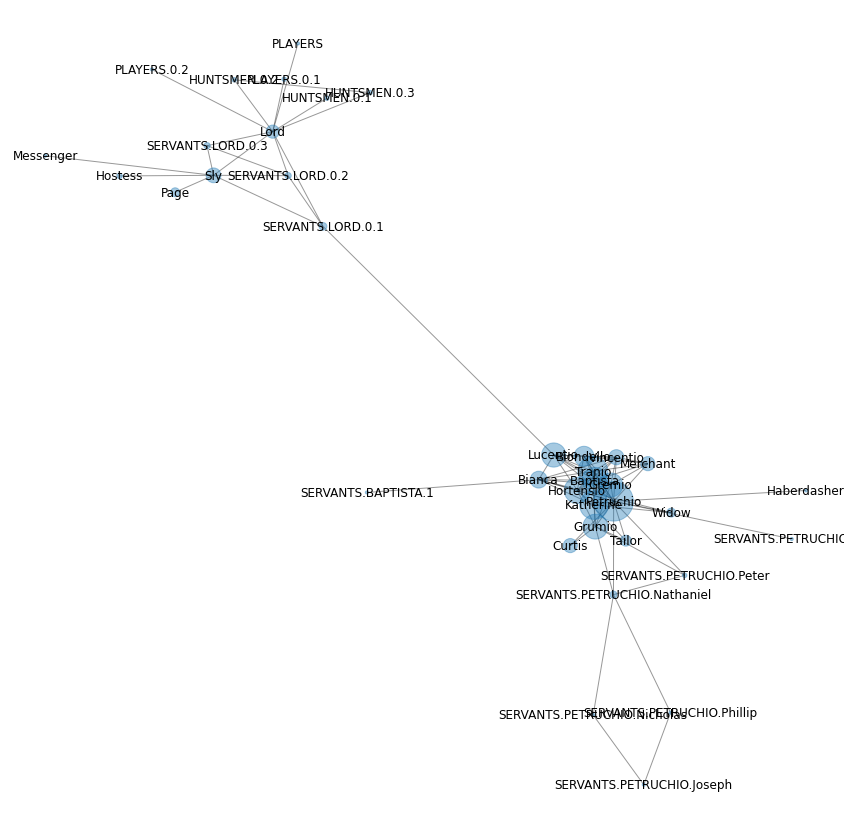

In [12]:
# Create an empty figure of size 15x15
fig = plt.figure(figsize=(15, 15))
# Compute the positions of the nodes using the spring layout algorithm
pos = nx.spring_layout(G, k=0.5, iterations=200)
# Then, add the edges to the visualization
nx.draw_networkx_edges(G, pos, alpha=0.4)
# Subsequently, add the weighted nodes to the visualization
nx.draw_networkx_nodes(G, pos, node_size=nodesizes, alpha=0.4)
# Finally, add the labels (i.e. the speaker IDs) to the visualization
nx.draw_networkx_labels(G, pos)
plt.axis('off');


In [13]:
import json
from networkx.readwrite import json_graph

with open('shrew.json', 'w') as f:
    json.dump(json_graph.node_link_data(G), f)

with open('shrew.json') as f:
    d = json.load(f)

G = json_graph.node_link_graph(d)
print(f"Graph with {len(G.nodes())} nodes and {len(G.edges())} edges.")

Graph with 37 nodes and 93 edges.
